<a href="https://colab.research.google.com/github/YaninaK/sales-forecast/blob/main/notebooks/02_Feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sales forecast for 20 stores for 31 days' period. 
## Feature extraction

* [EDA: omissions, clustering & Fourier transformations](
https://colab.research.google.com/drive/1udCgyEt7lusSY43lnduVDEnZvdvVEt9h?usp=sharing)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone -q https://github.com/YaninaK/sales-forecast.git
!pip install -r sales-forecast/requirements_Colab.txt -q 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.2/358.2 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 KB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 65.3 MB/s eta 0:00:00


In [3]:
%cd sales-forecast

/content/sales-forecast


In [4]:
import sys
import os

sys.path.append(os.getcwd())
sys.path.append(os.path.join(os.getcwd(), "src", "sales_forecast"))

In [5]:
import random
import pandas as pd
import numpy as np
import scipy.stats as st

from data.make_dataset import load_data, get_dataset
from data.impute_data import impute
from data.validation import train_validation_split
from data.johnson_su_transformation import JohnsonSU
from data.clean_data import clean_outliers
from features.time_series_clusters import get_clusters
from features.features_fourier import get_fourier_features
from features.build_dataset import get_features

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
PATH = '/content/drive/MyDrive/ML_projects/01_Time_series/sales_forecast/'
DEFAULT_RANDOM_SEED = 3

In [8]:
def set_all_seeds(seed=DEFAULT_RANDOM_SEED):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)

set_all_seeds()

## 1. Data ingestion

In [9]:
data = load_data(PATH)

print(f'data.shape = {data.shape}\n')
data.head(2)

data.shape = (8230, 3)



,id,dt,target
0,0,2016-01-02,747.8
1,0,2016-01-03,681.2


In [10]:
data = get_dataset(data)
data = impute(data)

print(f'data.shape = {data.shape}\n')
data.head(2)

data.shape = (468, 20)



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
dt,,,,,,,,,,,,,,,,,,,,
2016-01-02,747.8,421.8,546.2,355.7,341.2,341.8,510.9,620.0,1603.4,726.9,656.7,477.2,656.5,697.0,518.4,728.1,343.8,328.5,617.2,370.3
2016-01-03,681.2,427.1,549.3,418.1,326.0,367.5,548.3,605.3,1608.6,677.0,674.4,446.7,685.1,711.2,528.4,758.0,361.6,331.1,523.4,382.3


## 2. Train test split

* 1st half of 2016 and 1st half of 2017

In [11]:
train_df, valid_df, train_df_past, valid_df_past = train_validation_split(data)
train_df.shape, valid_df.shape, train_df_past.shape, valid_df_past.shape

((127, 20), (27, 20), (154, 20), (27, 20))

## 3. Data transformations

### 3.1 Johnson SU transformation

In [12]:
scaler = JohnsonSU()
scaler.fit(train_df.astype(float))

train_df = scaler.transform(train_df.astype(float))
valid_df = scaler.transform(valid_df.astype(float))

X_scaled = pd.concat([train_df, valid_df], axis=0)

In [13]:
scaler_past = JohnsonSU()
scaler_past.fit(train_df_past.astype(float))

X_past_scaled = scaler_past.transform(train_df_past)

### 3.2 Clean outliers

In [14]:
X_scaled = clean_outliers(X_scaled)

Number of outliers = 8


## 4. Get clusters

In [15]:
clusters = get_clusters(X_scaled)

print(f'clusters.shape = {clusters.shape}\n')
clusters.sample(5)

clusters.shape = (20, 5)



,0,1,2,3,4
14,0,1,0,0,0
2,0,0,0,0,1
1,0,1,0,0,0
17,0,0,0,0,1
4,1,0,0,0,0


## 5. Fourier features

In [16]:
X = get_fourier_features(X_scaled, clusters)
X.shape

(154, 20, 6)

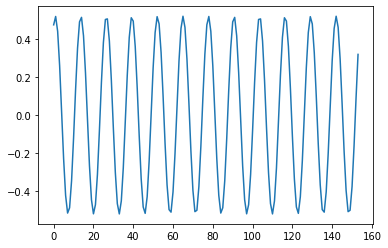

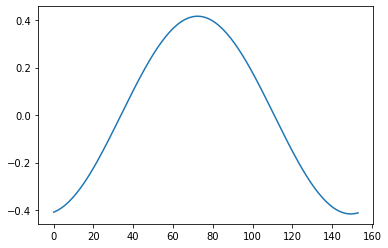

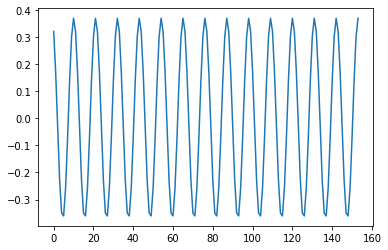

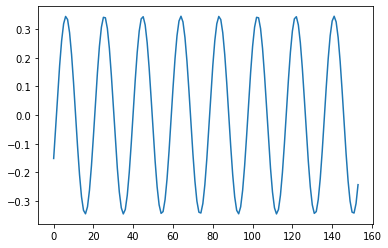

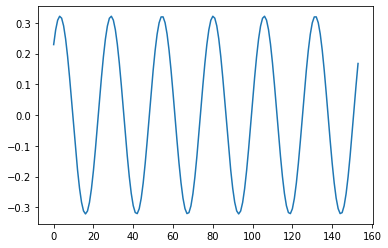

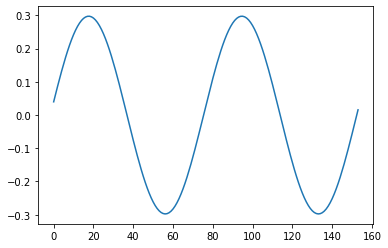

In [17]:
for i in range(X.shape[-1]):
  plt.plot(X[:, 4, i])
  plt.show();

## 6. Generate features





In [18]:
def get_features(
    X_scaled: pd.DataFrame,
    X_past_scaled: pd.DataFrame,
    clusters: pd.DataFrame,
) -> np.array:
    """
    Builds dataset for LSTM model
    """

    time_seq = X_scaled.shape[0] - 1

    a = X_scaled.values
    b = X_past_scaled.values

    n = 6
    c = np.empty((X_scaled.shape[0], X_scaled.shape[1]))
    c[n:, :] = X_scaled.iloc[:-n, :]

    n = 30
    d = np.empty((X_scaled.shape[0], X_scaled.shape[1]))
    d[n:, :] = X_scaled.iloc[:-n, :]

    X1 = np.vstack([a, b, a - b, c, a - c, d, a - d]).reshape(7, -1, X_scaled.shape[1])
    X1 = np.moveaxis(X1, 0, -1)[-time_seq:, :, :]

    X2 = get_1st_differences(X_scaled)
    X3 = get_2nd_differences(X_scaled)
    X4 = get_moments(X_scaled)
    X5 = get_rolling_means(X_scaled)

    X6 = clusters.values.repeat(time_seq, axis=0).reshape(
        clusters.shape[0], -1, clusters.shape[1]
    )
    X6 = np.moveaxis(X6, 1, 0)
    X7 = get_fourier_features(X_scaled, clusters)[-time_seq:, :, :]

    return np.concatenate([X1, X2, X3, X4, X5, X6, X7], axis=-1)


def get_1st_differences(X_scaled: pd.DataFrame, periods=["D", "W", "M"]) -> np.array:
    df = pd.DataFrame(index=X_scaled.index[1:])
    for t in periods:
        a1 = X_scaled.resample(t).median()
        X1 = a1.values[1:, :] - a1.values[:-1, :]
        X2 = (a1.values[1:, :] - a1.values[:-1, :]) / a1.values[:-1, :]
        X = pd.DataFrame(np.hstack([X1, X2]), index=a1.index[1:])
        df = df.merge(X, on="dt", how="left").bfill().ffill()

        X = df.values.reshape(len(df), -1, X_scaled.shape[1])

    return np.moveaxis(X, 1, -1)


def get_2nd_differences(X_scaled: pd.DataFrame, periods=["W", "M"]) -> np.array:
    df = pd.DataFrame(index=X_scaled.index[1:])
    for t in periods:
        a1 = X_scaled.resample(t).median()
        X = a1.values[1:, :] - a1.values[:-1, :]
        X = pd.DataFrame(X[1:, :] - X[:-1, :], index=a1.index[2:])
        df = df.merge(X, on="dt", how="left").bfill().ffill()

        X = df.values.reshape(len(df), -1, X_scaled.shape[1])

    return np.moveaxis(X, 1, -1)


def get_moments(X_scaled: pd.DataFrame, periods=["W", "M"]) -> np.array:
    df = pd.DataFrame(index=X_scaled.index)
    for t in periods:
        f = X_scaled.resample(t)
        df = pd.concat(
            [
                df,
                f.median(),
                f.mean(),
                f.std(),
                f.mean() / f.std(),
                f.agg(st.skew),
                f.agg(st.kurtosis),
            ],
            axis=1,
        ).bfill()
    df = pd.DataFrame(index=X_scaled.index[1:]).merge(df, on="dt", how="left")

    X = df.values.reshape(len(df), -1, X_scaled.shape[1])

    return np.moveaxis(X, 1, -1)


def get_rolling_means(X_scaled: pd.DataFrame, windows=[6, 24]) -> np.array:
    df = pd.DataFrame(index=X_scaled.index)
    for w in windows:
        f = X_scaled.rolling(w)
        df = pd.concat([df, X_scaled.rolling(w).mean()], axis=1).bfill()
    df = pd.DataFrame(index=X_scaled.index[1:]).merge(df, on="dt", how="left")

    X = df.values.reshape(len(df), -1, X_scaled.shape[1])

    return np.moveaxis(X, 1, -1)


In [19]:
X = get_features(X_scaled, X_past_scaled, clusters)
X.shape

(153, 20, 40)